In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# Branch Analysis on a Transmon-Oscillator System

## Step 1: Define the system

In [2]:
tmon = scq.Transmon(
    EJ = 20, 
    EC = 0.3, 
    ng = 0.25, 
    ncut = 100,
    truncated_dim = 10,
)

res = scq.Oscillator(
    E_osc = 5,
    l_osc = 1,
    truncated_dim = 50,
)

hilbertspace = scq.HilbertSpace([tmon, res])

hilbertspace.add_interaction(
    g=0.05,
    op1=tmon.n_operator,
    op2=res.n_operator
)

In [3]:
EC = 0.22
EJ = 0.22 * 110
E_osc = 7.50  # GHz, resonator frequency

tmon = scq.Transmon(
    EJ=EJ,      # Josephson energy
    EC=EC,      # Charging energy
    ng=0.0,     # Offset charge
    ncut=31,    # Charge basis cutoff
    truncated_dim=10  # Number of levels to keep
)


res = scq.Oscillator(E_osc=E_osc, truncated_dim=5)

hilbertspace = scq.HilbertSpace([tmon, res])

g = -0.120*1j

hilbertspace.add_interaction(
    expr="g * n * a - g * n * adag",
    op1=("n", tmon.n_operator),
    op2=("adag", res.creation_operator),
    op3 = ("a", res.annihilation_operator),
    add_hc=False
)

## Step 2: Generate and visualize the dressed state labeling

#### Generate the lookup table
by performing branch analysis (`ordering='LX'`)

For more details, please refer to the documentation of `HilbertSpace` (Insert link here)

In [4]:
hilbertspace.generate_lookup(
    ordering='LX'
)

In [5]:
def organize_branches(
    self,
    primary_mode_idx: int,
    observable = "E",
    param_ndindices = 0,
):
    """
    Helper function for branch analysis. This computes relevant observables
    for each eigenstate, and organizes them by bare labels. Branch analysis 
    should be performed prior to this, either by 
    `HilbertSpace.generate_lookup(ordering='LX')` or `ParameterSweep(labeling_scheme='LX')`.
    
    The observables computed are: energy, occupation number, energy modulo resonator mode energy (we refer to it as the primary mode).

    Parameters
    ----------
    primary_mode_idx: int
        The index of the primary mode (the mode whose eigenstates form the branches, e.g. the resonator mode).
    observable: Literal["E", "N", "EM"]
        The observable to be computed. 
        "E": eigenenergy, "N": total occupation number other than the primary mode, "EM": eigenenergy modulo the 0-1 energy of the primary mode.

    Returns
    -------
    array
        The expectation values of the observable organized by the bare state labels.
    """
    # Transform the dressed_indices array from 1D to 2D, 
    # now each array index is corresponding to a bare state index
    dims = self.hilbertspace.subsystem_dims
    branch_indices = self["dressed_indices"][param_ndindices].reshape(dims)

    # Ingredients to compute the y values
    primary_mode = self.hilbertspace.subsystem_list[primary_mode_idx]
    if observable == "N":
        # The occupation number operator for the non-primary modes
        N_ops = [
            scq.identity_wrap(
                qt.num(subsys.truncated_dim), 
                subsys, 
                self.hilbertspace.subsystem_list,
                op_in_eigenbasis = True
            )
            for subsys in self.hilbertspace.subsystem_list
            if subsys != primary_mode
        ]
        N_op = sum(N_ops)
    elif observable == "EM":
        # The 01 energy of the primary mode for taking modulo
        E_mod_arr = self["bare_evals"][primary_mode_idx][param_ndindices]
        E_mod = E_mod_arr[1] - E_mod_arr[0]
    
    # eigenenergies and eigenstates are precomputed in the HilbertSpace object
    # as well as the ParameterSweep object
    evals = self["evals"][param_ndindices]
    evecs = self["evecs"][param_ndindices]

    # calculate observable values
    obs_list = np.zeros_like(branch_indices, dtype=float)
    for idx, drs_idx in np.ndenumerate(branch_indices):
        
        if observable == "E":
            obs = evals[drs_idx]
            
        elif observable == "N":
            obs = qt.expect(N_op, evecs[drs_idx])
            
        elif observable == "EM":
            obs = evals[drs_idx] % E_mod

        obs_list[idx] = obs

    return obs_list

colors = [    # from https://arxiv.org/abs/2107.02270
    "#3f90da", "#ffa90e", "#bd1f01", "#832db6", "#94a4a2", 
    "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"
]

def plot_branches(
    N_array, 
    ax = None
):
    """
    Visualize the results of branch analysis.
    
    Parameters  
    ----------
    N_list: np.ndarray  
        The expectation values of the qubit occupation number 
        organized by the bare state labels.
    ax: matplotlib.axes.Axes  
        The axes to plot the branches on.
    """
    # branch analysis may be incorrect for eigenstates near the truncation 
    # we define a cutoff to ignore these eigenstates
    branch_cutoff = slice(None, -5)

    x_list = np.arange(N_array.shape[1])
    
    if ax is None:
        fig, ax = plt.subplots()
        
    for idx in range(N_array.shape[0]):
        ax.plot(
            x_list[..., branch_cutoff], 
            N_array[idx][..., branch_cutoff], 
            label = f"Branch {idx}", 
            color = colors[idx]
        )

    ax.set_xlabel("Branch index (Resonator occupation number)")
    ax.set_ylabel("Qubit occupation number")
    ax.grid()

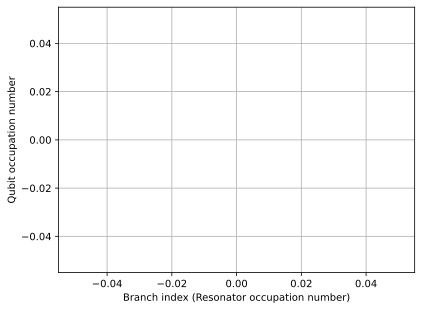

In [6]:
# compute the observables and organize them by branch indices
%matplotlib inline
N_list = organize_branches(
    hilbertspace,
    primary_mode_idx = 1,
    observable = "N",
)

# plot the branches
plot_branches(N_list)
plt.show()

## Parameter Sweep
For each parameter point, perform branch analysis 

#### Define the `ParameterSweep` object
sweep over the resonator frequency

In [7]:
# define a ParameterSweep object that sweeps over the resonator frequency
def update_hilbertspace(
    E_osc,
):
    res.E_osc = E_osc

swept_para = {"E_osc": np.linspace(7.5, 7.5, 1)}

update_info = {
    "E_osc": [res],
}

sweep = scq.ParameterSweep(
    hilbertspace,
    swept_para,
    update_hilbertspace,
    evals_count = hilbertspace.dimension,
    subsys_update_info = update_info,
    labeling_scheme = "LX",
)

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/1 [00:00<?, ?it/s]

#### Plots
Dispersive shift

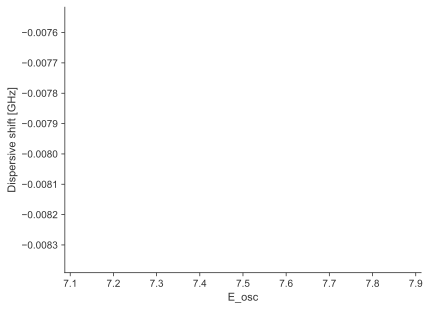

In [8]:
# for static plots
%matplotlib inline

sweep["chi"][0, 1][..., 1].plot()
plt.ylabel("Dispersive shift [GHz]")
plt.show()

Branches

In [9]:
# for interactive widgets
%matplotlib notebook  

from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    # Recompute branches at this frame-index
    N_list = organize_branches(
        sweep,
        primary_mode_idx=1,
        observable="N",
        param_ndindices=frame,
    )
    plot_branches(N_list, ax=ax)
    ax.set_title(f"E_osc = {swept_para['E_osc'][frame]:.3f} GHz")
    return ax

# Build the animation, one frame per integer
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, len(swept_para["E_osc"])), 
    interval=100,     # time interval between frames (ms)
    blit=False,
)

# Render as an inline HTML5 animation
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>